In [2]:
import os
from shapely.geometry import Polygon #import shapely
import cv2 # import opencv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

os.chdir('/Users/jmccarty/GitHub/22spring_templatematching_carto')

In [3]:
def crop_image(image,y_start,x_start,height,width):
    return image[y_start:y_start+height,x_start:x_start+width]

def mask_to_polygon(img):
    
    # apply the cv2 find contours function to the "img" (this is the binary mask array you created)
    contours = cv2.findContours(img,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)

    # cv2 returns the contour file with an extra dimension, so you just need to simplfy that array
    contour = np.squeeze(contours[0])

    # then just apply the shapely Polygon function to the returned contours.
    polygon = Polygon(contour)

    return polygon
    # ffrom there you should be able to save the polygon to a .shp file. 

Data Type: uint8
Min: 0.000, Max: 255.000


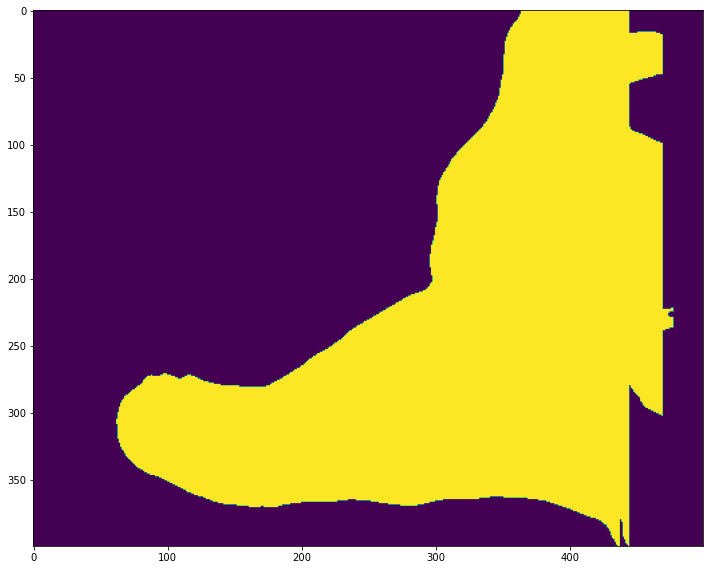

In [4]:

path_sample_image = os.path.join(os.getcwd(),'QATM/binary_result/LKg_1092_1990.png')

img = crop_image(cv2.imread(path_sample_image),7200,9500,400,500)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print('Data Type: %s' % img.dtype)
print('Min: %.3f, Max: %.3f' % (img.min(), img.max()))

fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(img) #y,x,h,w

In [5]:
poly = mask_to_polygon(img)

In [7]:
poly.area

78731.0